In [1]:
!pip install efficientnet

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall

import cv2

import streamlit as st

/Users/lakshmi/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/lakshmi/Library/Python/3.8/lib/python/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
epochs = 5

In [4]:
from os import listdir
from os.path import join, isfile
files = listdir('/Users/lakshmi/Downloads/PlantVillage/train')
files = [f.lower() for f in files]   # Convert to lower case
sorted(files)

['.ds_store',
 'apple___apple_scab',
 'apple___black_rot',
 'apple___cedar_apple_rust',
 'apple___healthy',
 'blueberry___healthy',
 'cherry_(including_sour)___healthy',
 'cherry_(including_sour)___powdery_mildew',
 'corn_(maize)___cercospora_leaf_spot gray_leaf_spot',
 'corn_(maize)___common_rust_',
 'corn_(maize)___healthy',
 'corn_(maize)___northern_leaf_blight',
 'grape___black_rot',
 'grape___esca_(black_measles)',
 'grape___healthy',
 'grape___leaf_blight_(isariopsis_leaf_spot)',
 'orange___haunglongbing_(citrus_greening)',
 'peach___bacterial_spot',
 'peach___healthy',
 'pepper,_bell___bacterial_spot',
 'pepper,_bell___healthy',
 'potato___early_blight',
 'potato___healthy',
 'potato___late_blight',
 'raspberry___healthy',
 'soybean___healthy',
 'squash___powdery_mildew',
 'strawberry___healthy',
 'strawberry___leaf_scorch',
 'tomato___bacterial_spot',
 'tomato___early_blight',
 'tomato___healthy',
 'tomato___late_blight',
 'tomato___leaf_mold',
 'tomato___septoria_leaf_spot',
 

In [5]:
label =files
NUM_CLASS=38

In [6]:
# fig, ax = plt.subplots(figsize=(16,7), nrows=1,ncols=2)
# df_train['label'].value_counts().plot(ax=ax[0],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for train set')
# df_val['label'].value_counts().plot(ax=ax[1],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for val set')
# plt.show()

In [7]:
train_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

# Only rescaling the val set
val_gen = ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

In [8]:
train_generator = train_gen.flow_from_directory(
    directory="/Users/lakshmi/Downloads/PlantVillage/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 43444 images belonging to 38 classes.


In [9]:
valid_generator = val_gen.flow_from_directory(
    directory='/Users/lakshmi/Downloads/PlantVillage/val',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

Found 10861 images belonging to 38 classes.


In [10]:
def see_examples(datagen, figsize=(16,16),nrows=4, ncols=4):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    batch_idx = np.random.randint(low=0, high=len(datagen), size=(nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            imgs, labels = datagen[batch_idx[i,j]]
            sample_idx = np.random.randint(low=0, high=len(imgs))
            img = imgs[sample_idx]
            label = labels[sample_idx]
            label = class_dict[np.argmax(label)]
            ax[i,j].axis('off')
            ax[i,j].imshow(img)
            ax[i,j].set_title(label)
    plt.show()

In [11]:
conv_base = efn.EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))
conv_base.trainable=False

In [12]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False 

In [13]:
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),
    
    Dense(units=512,activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=NUM_CLASS, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [15]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=15),
    ModelCheckpoint('/Users/lakshmi/Downloads/PlantVillage/best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.001)
]

metrics = [
    CategoricalAccuracy(), 
    F1Score(num_classes=NUM_CLASS), 
    Precision(), 
    Recall(), 
#     AUC()
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [16]:
history = model.fit(train_generator,epochs=epochs, batch_size=BATCH_SIZE,
                  validation_data=valid_generator,callbacks= callbacks
                             )

Epoch 1/5
679/679 [==============================] - ETA: 0s - loss: 0.4451 - categorical_accuracy: 0.8789 - f1_score: 0.8369 - precision: 0.9417 - recall: 0.8439

/Users/lakshmi/Library/Python/3.8/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


679/679 [==============================] - 1149s 2s/step - loss: 0.4451 - categorical_accuracy: 0.8789 - f1_score: 0.8369 - precision: 0.9417 - recall: 0.8439 - val_loss: 0.1381 - val_categorical_accuracy: 0.9607 - val_f1_score: 0.9499 - val_precision: 0.9650 - val_recall: 0.9567 - lr: 0.0010
Epoch 2/5
679/679 [==============================] - 1023s 2s/step - loss: 0.1315 - categorical_accuracy: 0.9618 - f1_score: 0.9471 - precision: 0.9695 - recall: 0.9548 - val_loss: 0.0727 - val_categorical_accuracy: 0.9790 - val_f1_score: 0.9690 - val_precision: 0.9829 - val_recall: 0.9766 - lr: 0.0010
Epoch 3/5
679/679 [==============================] - 996s 1s/step - loss: 0.0988 - categorical_accuracy: 0.9713 - f1_score: 0.9615 - precision: 0.9760 - recall: 0.9665 - val_loss: 0.0652 - val_categorical_accuracy: 0.9820 - val_f1_score: 0.9776 - val_precision: 0.9836 - val_recall: 0.9804 - lr: 0.0010
Epoch 4/5
679/679 [==============================] - 982s 1s/step - loss: 0.0805 - categorical_accu

In [17]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,categorical_accuracy,f1_score,precision,recall,val_loss,val_categorical_accuracy,val_f1_score,val_precision,val_recall,lr
0,0.445091,0.878902,"[0.7564655, 0.8304721, 0.749354, 0.8868216, 0....",0.941671,0.843914,0.138061,0.960685,"[0.9763779, 0.984127, 1.0, 0.9907976, 0.993288...",0.964989,0.956726,0.001
1,0.131460,0.961836,"[0.9355797, 0.9598393, 0.95022625, 0.9676437, ...",0.969498,0.954769,0.072690,0.979007,"[0.9635627, 0.992, 0.9734514, 0.97458893, 0.99...",0.982858,0.976614,0.001
2,0.098790,0.971273,"[0.9589589, 0.9687184, 0.94545454, 0.98024315,...",0.976012,0.966532,0.065235,0.981954,"[0.9767442, 0.9879519, 0.9908257, 0.98470944, ...",0.983649,0.980389,0.001
3,0.080483,0.977074,"[0.95841587, 0.9787234, 0.94784576, 0.98293513...",0.980592,0.973414,0.064800,0.982046,"[0.992, 1.0, 0.9818182, 0.9782609, 0.99337745,...",0.983298,0.981125,0.001
4,0.078227,0.978685,"[0.9594462, 0.9768844, 0.9749431, 0.98363155, ...",0.982078,0.975025,0.063356,0.983611,"[1.0, 0.99193555, 0.9908257, 0.993921, 0.99665...",0.985596,0.982782,0.001


In [18]:
history_df['f1_score'] = history_df['f1_score'].apply(np.mean)
history_df['val_f1_score'] = history_df['val_f1_score'].apply(np.mean)

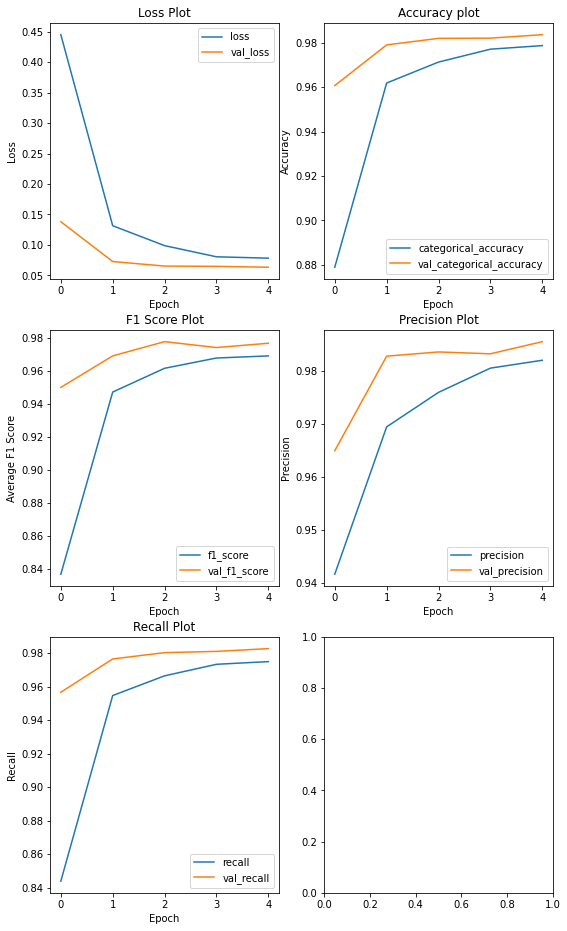

In [19]:
fig, ax = plt.subplots(figsize=(9,16), nrows=3,ncols=2)
history_df[['loss','val_loss']].plot(ax=ax[0,0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
history_df[['categorical_accuracy','val_categorical_accuracy']].plot(
    ax=ax[0,1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
history_df[['f1_score','val_f1_score']].plot(ax=ax[1,0],xlabel='Epoch',ylabel='Average F1 Score',title='F1 Score Plot')
history_df[['precision','val_precision']].plot(ax=ax[1,1],xlabel='Epoch',ylabel='Precision',title='Precision Plot')
history_df[['recall','val_recall']].plot(ax=ax[2,0],xlabel='Epoch',ylabel='Recall',title='Recall Plot')
plt.show()

In [22]:
best_model = load_model('/Users/lakshmi/Downloads/PlantVillage/best_model.h5')

In [ ]:
val_loss,val_acc, val_f1, val_precision, val_recall = best_model.evaluate(valid_generator)

In [23]:
model.save('/Users/lakshmi/Desktop/Plant_Pest_Project/Plant_Pest_Classifier.h5')

/Users/lakshmi/Library/Python/3.8/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# #### edited today : 21 april (all edits in one cell)

# model = tf.keras.models.load_model("/Users/lakshmi/Desktop/Major_Project_Files/Plant_Pest_Classifier.h5")
# def process_frame(frame):
#     # Resize the frame to match the input size of the model (224x224)
#     processed_frame = cv2.resize(frame, (224, 224))
#     # Convert the frame to RGB color space (if it's in BGR)
#     processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
#     # Normalize pixel values to the range [0, 1]
#     processed_frame = processed_frame / 255.0
#     return processed_frame


# def main():
#     # Set up video capture from webcam
#     st.title ("Plant Pest Classifier")
#     cap = cv2.VideoCapture(0)
#     video_placeholder = st.empty()

#     # Main Streamlit app loop
#     while cap.isOpened():
#         # Read frame from the video stream
#         ret, frame = cap.read()
        
#         if not ret:
#             break
        
#         processed_frame = process_frame(frame)
#         #processed_frame = np.expand_dims(processed_frame, axis=0)
#         prediction = model.predict(np.expand_dims(processed_frame, axis=0))
#         # Expand dimensions to match the expected input shape of the model
#         predicted_label = np.argmax(prediction, axis=1)[0] 
        
#         # Interpret the prediction (replace this with your specific interpretation logic)
#         # Assuming you have a list of class labels
#         class_labels = ['.ds_store',
#  'apple___apple_scab',
#  'apple___black_rot',
#  'apple___cedar_apple_rust',
#  'apple___healthy',
#  'blueberry___healthy',
#  'cherry_(including_sour)___healthy',
#  'cherry_(including_sour)___powdery_mildew',
#  'corn_(maize)___cercospora_leaf_spot gray_leaf_spot',
#  'corn_(maize)___common_rust_',
#  'corn_(maize)___healthy',
#  'corn_(maize)___northern_leaf_blight',
#  'grape___black_rot',
#  'grape___esca_(black_measles)',
#  'grape___healthy',
#  'grape___leaf_blight_(isariopsis_leaf_spot)',
#  'orange___haunglongbing_(citrus_greening)',
#  'peach___bacterial_spot',
#  'peach___healthy',
#  'pepper,_bell___bacterial_spot',
#  'pepper,_bell___healthy',
#  'potato___early_blight',
#  'potato___healthy',
#  'potato___late_blight',
#  'raspberry___healthy',
#  'soybean___healthy',
#   'squash___powdery_mildew',
#  'strawberry___healthy',
#  'strawberry___leaf_scorch',
#  'tomato___bacterial_spot',
#  'tomato___early_blight',
#  'tomato___healthy',
#  'tomato___late_blight',
#  'tomato___leaf_mold',
#  'tomato___septoria_leaf_spot',
#  'tomato___spider_mites two-spotted_spider_mite',
#  'tomato___target_spot',
#  'tomato___tomato_mosaic_virus',
#  'tomato___tomato_yellow_leaf_curl_virus']  
#         predicted_class = class_labels[predicted_label]

#         # Display the predicted class label on the frame
#         st.write("Predicted Class:", predicted_class)
#         video_placeholder.image(processed_frame, channels="RGB", use_column_width=True, caption="Webcam Feed")
#         # Display the frame
#         #cv2.imshow('Frame', frame)

#                # Break the loop if 'q' is pressed
#     #     if cv2.waitKey(1) & 0xFF == ord('q'):
#     #         break

#     # # Release the capture
#     cap.release()
#     # cv2.destroyAllWindows()

        

        # Display the frame with a bounding box
        
        

#     # Release the video capture object
#     cap.release()

# if __name__ == "__main__":
#     main()
    

In [28]:
import cv2
import streamlit as st
from PIL import Image
import time


In [30]:
FRAME_RATE = 1 / 2
def process_frame(frame):
    # Convert frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Resize frame to the desired input shape of the model
    resized_frame = cv2.resize(frame_rgb, (224, 224))
    preprocessed_frame = resized_frame / 255.0

    return preprocessed_frame

In [32]:
def main():
    # Load pre-trained CNN model
    model = tf.keras.models.load_model('/Users/lakshmi/Desktop/Plant_Pest_Classifier.h5')

    # Open video capture device
    #camera on
    cap = cv2.VideoCapture(0)
    last_processed_time = time.time() 

    
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            break
        current_time = time.time()
        if current_time - last_processed_time >= FRAME_RATE:
            last_processed_time = current_time
        # Process frame
            processed_frame = process_frame(frame)

        # Expand dimensions to match the expected input shape of the model
            processed_frame = np.expand_dims(processed_frame, axis=0)
        #st.image(processed_frame, channels='BGR', caption='Object Detection', use_column_width=True)
            prediction = model.predict(processed_frame)
        #predicted_labels = np.argmax(prediction, axis=1)
            predicted_label = np.argmax(prediction, axis=1)[0]  # Get the predicted label for the first frame

        # Interpret the prediction (replace this with your specific interpretation logic)
        # Assuming you have a list of class labels
            class_labels = ['.ds_store',
 'apple___apple_scab',
 'apple___black_rot',
 'apple___cedar_apple_rust',
 'apple___healthy',
 'blueberry___healthy',
 'cherry_(including_sour)___healthy',
 'cherry_(including_sour)___powdery_mildew',
 'corn_(maize)___cercospora_leaf_spot gray_leaf_spot',
 'corn_(maize)___common_rust_',
 'corn_(maize)___healthy',
 'corn_(maize)___northern_leaf_blight',
 'grape___black_rot',
 'grape___esca_(black_measles)',
 'grape___healthy',
 'grape___leaf_blight_(isariopsis_leaf_spot)',
 'orange___haunglongbing_(citrus_greening)',
 'peach___bacterial_spot',
 'peach___healthy',
 'pepper,_bell___bacterial_spot',
 'pepper,_bell___healthy',
 'potato___early_blight',
 'potato___healthy',
 'potato___late_blight',
 'raspberry___healthy',
 'soybean___healthy',
 'squash___powdery_mildew',
 'strawberry___healthy',
 'strawberry___leaf_scorch',
 'tomato___bacterial_spot',
 'tomato___early_blight',
 'tomato___healthy',
 'tomato___late_blight',
 'tomato___leaf_mold',
 'tomato___septoria_leaf_spot',
 'tomato___spider_mites two-spotted_spider_mite',
 'tomato___target_spot',
 'tomato___tomato_mosaic_virus',
 'tomato___tomato_yellow_leaf_curl_virus']  
            predicted_class = class_labels[predicted_label]

        # Display the predicted class label on the frame
            cv2.putText(frame, f'Predicted Class: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Display the frame
            cv2.imshow('Frame', frame)

        # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    # Release the capture
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


1/1 [==============================] - 0s 37ms/step
